# Procesado Espectros Raman Sonda 532nm

En este Notebook se realiza el procedimeinto necesario para preprocesar y unificar los espectros obtenidos de la Sonda 532nm. Tenemos tres fuentes diferentes de información:
* Medidas realizadas el año anterior. De estas medidas obtenemos espectros preprocesados de varias muestras estudiadas. También disponemos de los espectros en bruto, pero al no tener el *background* no es posible realizar un preprocesado a las muestras.
* Medidas repetidas este año de la colección de *Littorina Obtusata*. 

In [19]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import shutil
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, Normalizer
from scipy.linalg import solveh_banded  # para hacer ALS
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.signal import argrelextrema
from itertools import product
from scipy.signal import savgol_filter
from functools import reduce

                                                                                              
# Ruta que contiene todos los archivos
folder_path_win_old = "D:/OneDrive - UNICAN/LIBS/raman/ConchasArq"
folder_path_mac_old = '/Users/drea/Library/CloudStorage/OneDrive-UNICAN/LIBS/raman/ConchasArq/'
folder_path_sonda_2024 = 'D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_nuevo_sonda'
folder_path = folder_path_sonda_2024

# Reunimos todos los archivos en un directorio. Para ello copiamos las carpetas de los archivos en una carpeta nueva
def copiar_carpetas(origen, destino):
    # Obtener la lista de carpetas en la carpeta de origen
    carpetas_origen = [nombre for nombre in os.listdir(origen) if os.path.isdir(os.path.join(origen, nombre))]

    # Copiar cada carpeta a la carpeta de destino si no existe
    for carpeta in carpetas_origen:
        ruta_origen = os.path.join(origen, carpeta)
        ruta_destino = os.path.join(destino, carpeta)
        if carpeta == "Fotos":
            shutil.rmtree(ruta_destino)  # Eliminar la carpeta "Fotos" si ya existe
        if not os.path.exists(ruta_destino):
            shutil.copytree(ruta_origen, ruta_destino)
            print(f"Carpeta {carpeta} copiada correctamente.")
        else:
            print(f"La carpeta {carpeta} ya existe en la carpeta de destino.")

copiar_carpetas(folder_path_win_old, folder_path_sonda_2024)

# Directorios de medida
directories = [directory for directory in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, directory)) and directory != "Fotos"]
print(f"Hay {len(directories)} medidas.")

La carpeta 09042024-160856_conchas_532nm_LIT1_n10_1000ms_0.05mm_50p_atras ya existe en la carpeta de destino.
La carpeta 10042024-103809_conchas_532nm_LIT2_n10_1000ms_0.05mm_50p_atras ya existe en la carpeta de destino.
La carpeta 10042024-152046_conchas_532nm_LIT3_n10_1000ms_0.05mm_50_atras ya existe en la carpeta de destino.
La carpeta 11042024-162047_conchas_532nm_LIT4_n10_1000ms_0.05mm_50p_caraabajo ya existe en la carpeta de destino.
La carpeta 17042024-150606_conchas_532nm_LIT5_n10_1000ms_0.05mm_50p_atras ya existe en la carpeta de destino.
La carpeta 17042024-184049_conchas_532nm_LIT6_n10_1000ms_0.15mm_50p_cara ya existe en la carpeta de destino.
La carpeta 18042024-125034_conchas_532nm_LIT6_n10_1000ms_0.05mm_50p_abajo ya existe en la carpeta de destino.
La carpeta 26042024-120745_conchas_532nm_LIT235.3_n10_1000ms_0.05mm_50p_abajo ya existe en la carpeta de destino.
La carpeta 26042024-141523_conchas_532nm_LIT235.3_n10_1000ms_0.05mm_50p_arriba ya existe en la carpeta de destino.

## 1. Espectros Raman de las muestras medidas en 2023
Se cargan y preparan los espectros medidos en el año 2023. Es necesario tener en cuenta que tienen un formato diferente de nombre de archivo.

In [8]:
folder_sonda_2013 = 'D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_original_sonda'
csv_files_sonda_2013 = [f for f in os.listdir(folder_sonda_2013) if f.endswith('.csv') and f.startswith('arq') or f.startswith('moderna')]

directorio_muestras = {'arq885' : 'LIT885.1',
            'arq235' : 'LIT235.3',
            'moderna1' : 'LIT1',
            'moderna2' : 'LIT2',
            'moderna3' : 'LIT3',
            'moderna4' : 'LIT4',
            'moderna5' : 'LIT5',
            'moderna6' : 'LIT6'}

def create_df_2023(folder_path, csv_files):
    dataframes = []
    lista_archivos = []
    lista_muestras = []
    for csv_file in csv_files:
        print('Processing', csv_file)
        df = pd.read_csv(os.path.join(folder_path, csv_file))
        nombre_archivo = csv_file.split('.')[0]
        nombre_muestra =nombre_archivo.split('_')[0]
        muestra = directorio_muestras[nombre_muestra]
        tipo_laser = 'Sonda 523nm'
        tipo =  nombre_archivo.split('_')[4]
        fecha_medida = csv_file.split('_')[5].split('-')[0]
        hora_medida = csv_file.split('_')[5].split('-')[1]
        df.index = df.index = pd.MultiIndex.from_tuples([( tipo_laser, muestra, tipo, fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df.index],
                                                   names=[ 'Instrumento',"Muestra", "Tipo", "Fecha","Hora", "Archivo","X", "Y"])
        # Guardamos el nombre de los archivos y de las muestras en lsitas
        lista_archivos.append(nombre_archivo)
        lista_muestras.append(nombre_muestra)
        # Agrega el DataFrame a la lista de DataFrames
        dataframes.append(df)
       # Concatena todos los DataFrames en uno solo
    data = pd.concat(dataframes)
    return data, lista_archivos, lista_muestras

data_sonda_2023, lista_archivos_2023, lista_muestras_2023 = create_df_2023(folder_sonda_2013, csv_files_sonda_2013)
# Guardamos el DataFrame en un archivo CSV
data_sonda_2023.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023.csv', index=True)

# Separamos los datos preprocesados, que son los que se utilizaran en este proyecto
data_sonda_preproc_2023 = data_sonda_2023.loc[data_sonda_2023.index.get_level_values('Tipo') == 'preproc']
data_sonda_preproc_2023.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_preproc_2023.csv', index=True)


Processing arq235_exported_csv_singlefile_preproc_11042023-154845_arq235_otravez_200mW_700mseg_40p_z=0.csv
Processing arq235_exported_csv_singlefile_preproc_20032023-110433_235-3_532nm.csv
Processing arq235_exported_csv_singlefile_raw_11042023-154845_arq235_otravez_200mW_700mseg_40p_z=0.csv
Processing arq235_exported_csv_singlefile_raw_20032023-110433_235-3_532nm.csv
Processing arq885_exported_csv_singlefile_preproc_11042023-125431_arq885_otravez_200mW_1seg_20p_z=0_zonalimpia.csv
Processing arq885_exported_csv_singlefile_preproc_11042023-131752_arq885_otravezz_200mW_1seg_20p_z=-0,5_zonalimpia.csv
Processing arq885_exported_csv_singlefile_preproc_19032023-201324_532nm.csv
Processing arq885_exported_csv_singlefile_preproc_19032023-215249_885-1_532nm_extratime.csv
Processing arq885_exported_csv_singlefile_preproc_21032023-114930_885-1_granArea_extraTime_532nm.csv
Processing arq885_exported_csv_singlefile_raw_11042023-125431_arq885_otravez_200mW_1seg_20p_z=0_zonalimpia.csv
Processing arq88

## 2. Espectros Raman de las muestras medidas en 2024

### 2.1. Archivos preprocesados con el programa de medida de Matlab

In [20]:
# Carga de archivos CSV en un DataFrame Preprocesados:
#################### Función para etiquetar las muestras #############################
def create_df_preproc(folder_path, folder_names):
    dataframes = []
    lista_archivos = []
    lista_muestras = []

    for folder in folder_names:
        path = os.path.join(folder_path, folder)
        if not os.path.exists(os.path.join(path, 'exported_preproc_exported.csv')):
            print('No exported files found in', folder)
            continue
        print('Processing', folder)
        csv_files = [f for f in os.listdir(path) if f.endswith('exported_preproc_exported.csv')]

        # Lee los archivos csv y los concatena en un solo DataFrame
        for csv_file in csv_files:
            df = pd.read_csv(os.path.join(path, csv_file))
            # print((os.path.join(path, csv_file)))
            nombre_archivo = folder+'_'+ csv_file.split("_")[1] # Nombre del archivo
            nombre_muestra = folder.split("_")[3] # Nombre de la muestra
            fecha_medida = folder.split("_")[0].split("-")[0]   # Fecha de la medida
            hora_medida = folder.split("_")[0].split("-")[1]    # Hora de la medida
            tipo = 'preproc'
            tipo_laser = 'Sonda 532nm'
            df.index = pd.MultiIndex.from_tuples([(tipo_laser, nombre_muestra, tipo, fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df.index],
                                                   names=[ 'Instrumento', "Muestra", "Tipo", "Fecha","Hora", "Archivo","X", "Y"])
            # Guardamos el nombre de los archivos y de las muestras en lsitas
            lista_archivos.append(nombre_archivo)
            lista_muestras.append(nombre_muestra)
            # Agrega el DataFrame a la lista

            # Preprocesamos el DataFrame 
    
            dataframes.append(df)
     

    # Concatena todos los DataFrames en uno solo
    data = pd.concat(dataframes)
    return data, lista_archivos, lista_muestras

# Carga de archivos CSV en un DataFrame Preprocesados:
data_sonda_preproc_2024, lista_archivos_preproc_2024, lista_muestras_preproc_2024 = create_df_preproc(folder_path_sonda_2024, directories)

# Guardamos el DataFrame en un archivo CSV
data_sonda_preproc_2024.to_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preproc.csv')


Processing 09042024-160856_conchas_532nm_LIT1_n10_1000ms_0.05mm_50p_atras
Processing 10042024-103809_conchas_532nm_LIT2_n10_1000ms_0.05mm_50p_atras
Processing 10042024-152046_conchas_532nm_LIT3_n10_1000ms_0.05mm_50_atras
Processing 11042024-162047_conchas_532nm_LIT4_n10_1000ms_0.05mm_50p_caraabajo
Processing 17042024-150606_conchas_532nm_LIT5_n10_1000ms_0.05mm_50p_atras
Processing 17042024-184049_conchas_532nm_LIT6_n10_1000ms_0.15mm_50p_cara
Processing 18042024-125034_conchas_532nm_LIT6_n10_1000ms_0.05mm_50p_abajo
Processing 26042024-120745_conchas_532nm_LIT235.3_n10_1000ms_0.05mm_50p_abajo
Processing 26042024-141523_conchas_532nm_LIT235.3_n10_1000ms_0.05mm_50p_arriba
Processing 29042024-163342_conchas_532nm_LIT885.1_n10_500ms_0.04mm_50p_abajo
Processing 30042024-103017_conchas_532nm_LIT921.1_n10_500ms_0.05mm_50p_abajo


### 2.1. Archivos en bruto

In [22]:
class WhittakerSmoother(object):
    def __init__(self, signal, smoothness_param, deriv_order=1):
        self.y = signal
        assert deriv_order > 0, 'deriv_order must be an int > 0'
        # Compute the fixed derivative of identity (D).
        d = np.zeros(deriv_order*2 + 1, dtype=int)
        d[deriv_order] = 1
        d = np.diff(d, n=
        deriv_order)
        n = self.y.shape[0]
        k = len(d)
        s = float(smoothness_param)
        # Here be dragons: essentially we're faking a big banded matrix D,
        # doing s * D.T.dot(D) with it, then taking the upper triangular bands.
        diag_sums = np.vstack([
            np.pad(s*np.cumsum(d[-i:]*d[:i]), ((k-i,0),), 'constant')
            for i in range(1, k+1)])
        upper_bands = np.tile(diag_sums[:,-1:], n)
        upper_bands[:,:k] = diag_sums
        for i,ds in enumerate(diag_sums):
            upper_bands[i,-i-1:] = ds[::-1][:i+1]
        self.upper_bands = upper_bands
    def smooth(self, w):
        foo = self.upper_bands.copy()
        foo[-1] += w  # last row is the diagonal
        return solveh_banded(foo, w * self.y, overwrite_ab=True, overwrite_b=True)

def als_baseline(intensities, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6, verbose=False):
    """
    Applies the asymmetric least squares (ALS) method to fit the baseline.

    Parameters:
    - intensities (numpy.ndarray or pandas.Series): Numpy array or pandas Series representing the Raman intensities.
    - asymmetry_param (float): Asymmetry parameter for the fit.
    - smoothness_param (float): Smoothness parameter for the fit.
    - max_iters (int): Maximum number of iterations.
    - conv_thresh (float): Convergence threshold.
    - verbose (bool): Flag to print debugging information.

    Returns:
    - baseline (numpy.ndarray): Numpy array representing the fitted baseline.
    """
    if isinstance(intensities, pd.Series):
        intensities = intensities.values

    smoother = WhittakerSmoother(intensities, smoothness_param, deriv_order=2)
    p = asymmetry_param
    w = np.ones(intensities.shape[0])

    for i in range(max_iters):
        z = smoother.smooth(w)
        mask = intensities > z
        new_w = p * mask + (1 - p) * (~mask)
        conv = np.linalg.norm(new_w - w)
        if verbose:
            print(i + 1, conv)
        if conv < conv_thresh:
            break
        w = new_w
    else:
        print('ALS did not converge in %d iterations' % max_iters)
    return z

def subtract_background (df, df_background):
    df_subtracted = df.sub(df_background.iloc[0], axis=1)
    return df_subtracted

def find_baseline(df, asymmetry_param=0.0001, smoothness_param=1e4,
                 max_iters=20, conv_thresh=1e-6):
    """
    Apply baseline correction to each row in a DataFrame.
    Input:
        df: DataFrame, contains the spectral data.
    Output:
        DataFrame, with baseline corrected for each spectrum.
    """
    D0_BL = df.copy()
    for i in range(len(df)):
        # Apply ALS baseline correction to each row
        bl = als_baseline(df.iloc[i, :].values, asymmetry_param, smoothness_param,
                 max_iters, conv_thresh)
        D0_BL.iloc[i, :] = bl
    return D0_BL

def correct_baseline(data, baseline):
    """
    Corrects the baseline of the data.
    Parameters:
    - data (pandas.DataFrame or pandas.Series): DataFrame or Series containing the data.
    - baseline (pandas.DataFrame or pandas.Series): DataFrame or Series with the baselines.
    Returns:
    - corrected_data (pandas.DataFrame): DataFrame with the corrected data.
    """
    # Ensure that both data and baseline are DataFrames
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    if not isinstance(baseline, pd.DataFrame):
        baseline = pd.DataFrame(baseline)
    # Perform baseline correction
    corrected_data = data.values - baseline.values
    # Convert the result back to a DataFrame while maintaining the same column names
    corrected_data = pd.DataFrame(corrected_data, columns=data.columns).copy()
    return corrected_data

def normalize_spectra(X_filtered):
    """
    Preprocessing of spectral data.
    Input:
        X_filtered: DataFrame, raw spectral data.
    Output:
        DataFrame, preprocessed spectral data.
    """
    X_norm_list = []
    for _, row in X_filtered.iterrows():
        # Normalize each spectrum by dividing by the sum and multiplying by a constant
        total = np.sum(row)
        X_norm_list.append(pd.DataFrame([row / total * 2000]))
    X_norm = pd.concat(X_norm_list, ignore_index=True)
    # Apply Savitzky-Golay filter for smoothing
    X_norm_flt = savgol_filter(X_norm, 21, 2)
    X_norm_flt = pd.DataFrame(X_norm_flt, columns=X_filtered.columns)
    '''# Perform baseline correction
    bl = find_baseline(X_norm_flt)
    X_norm_flt = X_norm_flt - bl'''
    # Standardize the data using StandardScaler
    scaler = StandardScaler()
    z_numpy = X_norm_flt.values
    z_numpy_scaled_rows = scaler.fit_transform(z_numpy.T).T
    X_norm_flt_stdz = pd.DataFrame(data=z_numpy_scaled_rows, columns=X_filtered.columns)
    return X_norm_flt_stdz

def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

def cut_spectrum(df, min_wavelength, max_wavelength):
    """
    Cuts the spectrum to a specific range.
    Parameters:
    - df (pandas.DataFrame): DataFrame containing the spectrum.
    - min_wavelength (int): Minimum wavelength.
    - max_wavelength (int): Maximum wavelength.
    Returns:
    - df_cut (pandas.DataFrame): DataFrame containing the spectrum within the specified range.
    """
    df_cut = df.loc[:, (df.columns >= min_wavelength) & (df.columns <= max_wavelength)]
    return df_cut

def preprocesado_raw(D_sonda,bg_sonda, asymmetry_param=0.0001, smoothness_param=1e4, min_wavelength = 700, max_wavelength =2500, max_iters=20, conv_thresh=1e-6):

    D_BG_sonda = subtract_background(D_sonda, bg_sonda)
    # Find baseline of Raman spectra data
    D_C_sonda = cut_spectrum(D_BG_sonda, max_wavelength, max_wavelength)
    D_BL_sonda = find_baseline(D_BG_sonda, asymmetry_param, smoothness_param, max_iters, conv_thresh)
    # Correct baseline of Raman spectra data
    D_BC_sonda = correct_baseline(D_sonda, D_BL_sonda)
    # Normalize Raman spectra data
    # D_N_sonda = SNV(D_BC_sonda)

    return D_BC_sonda #D_N_sonda

# df_preproc = preprocesado_raw(df,df_background)

# df_preproc.mean(axis=0).plot()

TypeError: '>=' not supported between instances of 'str' and 'int'

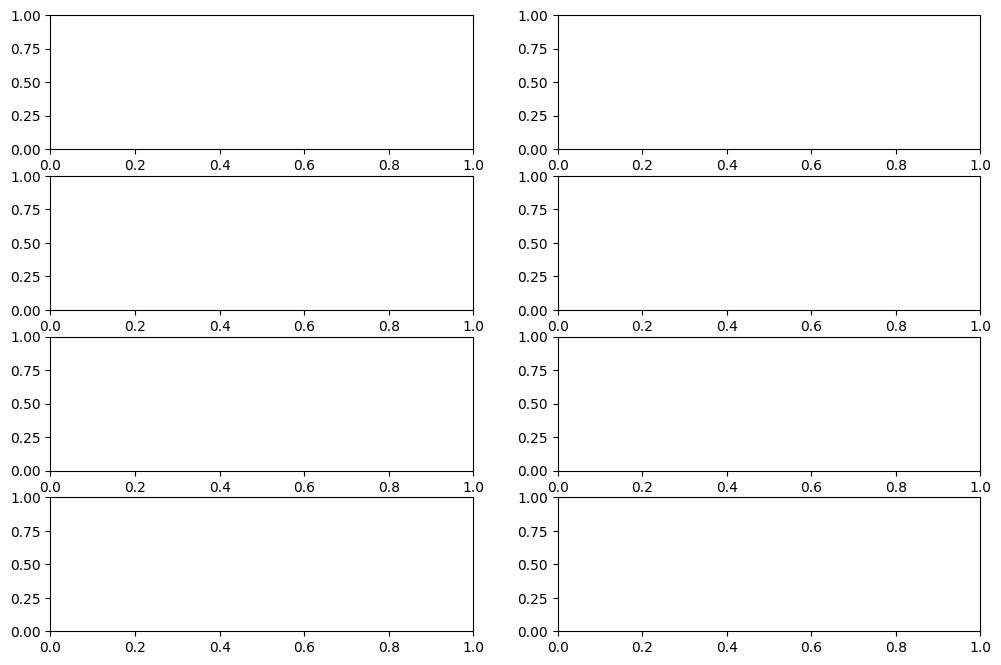

In [23]:
# asymmetry_param=[0.001, 0.01]
# smoothness_param=[1e4, 5e4, 1e5, 1e6]
# max_iters=20
# conv_thresh=1e-6

# for a, s in product(asymmetry_param, smoothness_param):
#     df_preproc = preprocesado_raw(df,df_background, a, s, max_iters, conv_thresh)
#     df_preproc.mean(axis=0).plot(label=f'asymmetry={a}, smoothness={s}')
# import matplotlib.pyplot as plt

# FILEPATH: /d:/OneDrive - UNICAN/TFM-ML-Raman-Conchas-Arqueologicas/Code/Notebooks/procesado_sonda532nm.ipynb
asymmetry_param=[0.001, 0.01]
smoothness_param=[1e4, 5e4, 1e5, 1e6]
max_iters=20
conv_thresh=1e-6

fig, axs = plt.subplots( len(smoothness_param),len(asymmetry_param), figsize=(12, 8))

for i, a in enumerate(asymmetry_param):
    for j, s in enumerate(smoothness_param):
        df_preproc = preprocesado_raw(df, df_background, a, s, max_iters, conv_thresh)
        ax = axs[j, i]
        df.mean(axis=0).plot(ax=ax)
        df_preproc.mean(axis=0).plot(ax=ax, label=f'asymmetry={a}, smoothness={s}')
        # ax.legend()
        ax.title.set_text(f'asymmetry={a}, smoothness={s}')

plt.tight_layout()
plt.show()

    # plt.legend()

<Axes: >

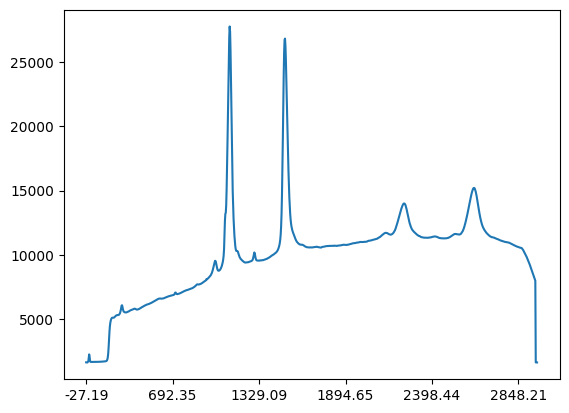

In [18]:
df.mean(axis=0).plot()

In [ ]:
def create_df_raw(folder_path, folder_names):
    dataframes = []
    lista_archivos = []
    lista_muestras = []
    background = []
    for folder in folder_names:
        path = os.path.join(folder_path, folder)
        if not os.path.exists(os.path.join(path, 'exported_raw_exported.csv')):
            print('No exported files found in', folder)
            continue
        print('Processing', folder)
        csv_files = [f for f in os.listdir(path) if f.endswith('exported_raw_exported.csv')]

        # Lee los archivos csv y los concatena en un solo DataFrame
        for csv_file in csv_files:
            df = pd.read_csv(os.path.join(path, csv_file), skiprows=[1], header=0)
            bg = pd.read_csv(os.path.join(path, csv_file), nrows=1)
            # print((os.path.join(path, csv_file)))
            nombre_archivo = folder+'_'+ csv_file.split("_")[1] # Nombre del archivo
            nombre_muestra = folder.split("_")[2] # Nombre de la muestra
            fecha_medida = folder.split("_")[0].split("-")[0]   # Fecha de la medida
            hora_medida = folder.split("_")[0].split("-")[1]    # Hora de la medida
            tipo = csv_file.split("_")[1]#.split("-")[0]    # Tipo de medida (preproc, raw)
            df.index = pd.MultiIndex.from_tuples([( nombre_muestra, tipo, fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df.index],
                                                   names=[ "Muestra", "Tipo", "Fecha","Hora", "Archivo","X", "Y"])
            # Guardamos el nombre de los archivos y de las muestras en lsitas
            lista_archivos.append(nombre_archivo)
            lista_muestras.append(nombre_muestra)
            # Agrega el DataFrame a la lista

            # Preprocesamos el DataFrame 
            df_prec = preprocesado_raw(df,bg)
            dataframes.append(df_prec)
            background.append(bg)

    # Concatena todos los DataFrames en uno solo
    data = pd.concat(dataframes)
    return lista_archivos, lista_muestras

ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations
ALS did not converge in 20 iterations


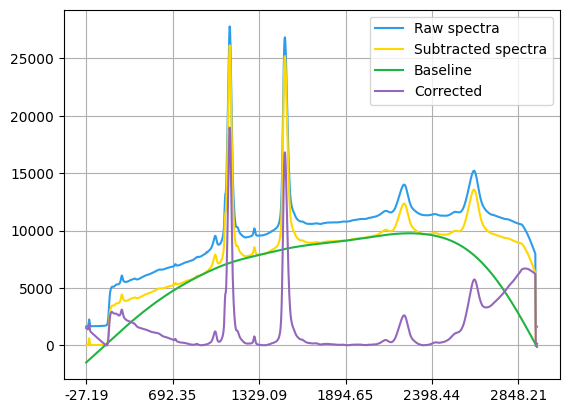

In [26]:
df.mean(axis=0).plot(label='1. Raw spectra', color='b')

def subtract (df, df_background):
    df_subtracted = df.sub(df_background.iloc[0], axis=1)
    return df_subtracted

df_subtracted = subtract(df, df_background)
df_subtracted.mean(axis=0).plot(label='2. Subtracted spectra', color='b' )

df_find_baseline = find_baseline(df_subtracted)
df_find_baseline.mean(axis=0).plot(color=colores[3], label='3. Baseline')

df_media_corrected = correct_baseline(df_subtracted, df_find_baseline)
df_media_corrected.mean(axis=0).plot(color = colores[4], label='4. Baseline Corrected')

plt.legend()
plt.grid(True)


<Axes: >

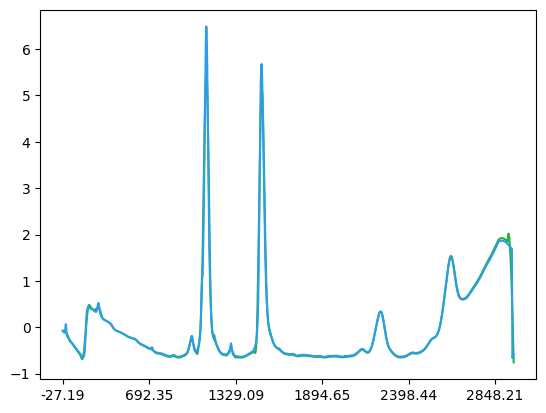

In [29]:
def SNV(input_data):
    """
    Procesado de datos: SNV (Standard Normal Variate).
    1) Media de cada channel --> axis=1 (todas las columnas).
    2) Se le resta su media a cada "channel" --> axis=0 (todas las filas).
    3) Divide cada channel por su StDev --> axis=1 (todas las columnas).
    :parameter *input_data*: matriz de datos, en formato: "channels(f) x time(c)".
    :return: matriz de datos, una vez normalizados
    """
    data_12 = input_data.sub(input_data.mean(axis=1), axis=0)
    data_snv = data_12.div(input_data.std(axis=1), axis=0)
    return data_snv

df_normalized = normalize_spectra(df_media_corrected)
df_svn = SNV(df_media_corrected)

df_media_normalized.mean(axis=0).plot(color = colores[3], label= "Normalizacion")
df_svn.mean(axis=0).plot(color = colores[0], label = "SVN")

In [8]:
df_fin = preprocesado_raw(df,df_background)
df_fin

,,-27.19,-23.36,-19.54,-15.72,-11.9,-8.08,-4.27,-0.46,3.35,7.16,...,2919.78,2921.86,2923.95,2926.03,2928.11,2930.19,2932.27,2934.34,2936.42,2938.5
-6.186,4.347,0.000007,0.000044,-0.000031,-0.000024,0.001279,0.003390,0.012801,0.018998,0.012215,0.003057,...,0.287941,0.284110,0.279825,0.275835,0.271418,0.266753,0.000019,6.410735e-07,-0.000012,0.000011
-6.136,4.347,0.000004,-0.000038,-0.000043,-0.000035,0.001180,0.003077,0.012574,0.019743,0.013396,0.003387,...,0.279237,0.275520,0.271754,0.268088,0.263441,0.259234,0.000040,-5.983869e-06,-0.000009,-0.000028
-6.086,4.347,-0.000016,0.000002,-0.000009,-0.000011,0.001257,0.003184,0.012928,0.020461,0.014193,0.003699,...,0.290566,0.286836,0.283107,0.278151,0.274212,0.270376,0.000039,1.702586e-05,0.000004,0.000018
-6.036,4.347,-0.000054,0.000013,-0.000044,-0.000032,0.001206,0.003035,0.013158,0.021848,0.015775,0.004080,...,0.289851,0.285513,0.282272,0.276641,0.273448,0.268582,0.000044,-9.563113e-06,-0.000016,0.000002
-5.986,4.347,-0.000031,-0.000025,-0.000031,0.000002,0.001166,0.002996,0.013257,0.022242,0.015805,0.003866,...,0.272132,0.268114,0.263400,0.260996,0.256683,0.252688,0.000021,-3.071235e-05,-0.000006,0.000026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-4.686,5.347,-0.000006,-0.000021,-0.000033,0.000035,0.001037,0.002750,0.012964,0.022544,0.016437,0.003922,...,0.248144,0.243913,0.240802,0.237263,0.233683,0.230166,0.000000,-1.279751e-05,-0.000030,0.000059
-4.636,5.347,-0.000009,-0.000021,0.000014,-0.000012,0.001042,0.002922,0.014226,0.025268,0.018843,0.004635,...,0.242981,0.239738,0.236262,0.233131,0.229869,0.225292,0.000033,6.698760e-07,-0.000023,0.000035
-4.586,5.347,0.000018,0.000030,-0.000040,0.000002,0.001110,0.002840,0.012850,0.022445,0.015873,0.003975,...,0.257864,0.255099,0.251250,0.247346,0.243519,0.240373,0.000031,1.765682e-05,-0.000020,0.000019
-4.536,5.347,-0.000006,0.000013,-0.000069,-0.000033,0.001115,0.002808,0.012944,0.023163,0.016736,0.004168,...,0.285640,0.281819,0.277565,0.272838,0.269144,0.264907,-0.000003,7.687316e-06,0.000018,0.000030


In [19]:
tipo_medida = 'all'
for folder in directories:
                path = os.path.join(folder_path, folder)
                if not os.path.exists(os.path.join(path, 'exported_preproc_exported.csv')) and not os.path.exists(os.path.join(path, 'exported_raw_exported.csv')):
                    print('No exported files found in', folder)
                    continue
                print('Processing', folder)
                # Lista de archivos en el directorio en función del tipo (all, exported_preproc_exported, exported_raw_exported)
                if tipo_medida == "all":
                    csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
                    print(csv_files)
                elif tipo_medida == "exported_preproc_exported" or tipo_medida == "exported_raw_exported":
                    csv_files = [f for f in os.listdir(path) if f.endswith(f'{tipo_medida}.csv')]
                    print(csv_files)

                for csv_file in csv_files:
                    print((os.path.join(path, csv_file)))

No exported files found in 09042024-160856_conchas_532nm_LIT1_n10_1000ms_0.05mm_50p_atras
Processing 10042024-103809_conchas_532nm_LIT2_n10_1000ms_0.05mm_50p_atras
['exported_preproc_exported.csv', 'exported_raw_exported.csv']
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\10042024-103809_conchas_532nm_LIT2_n10_1000ms_0.05mm_50p_atras\exported_preproc_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\10042024-103809_conchas_532nm_LIT2_n10_1000ms_0.05mm_50p_atras\exported_raw_exported.csv
Processing 10042024-152046_conchas_532nm_LIT3_n10_1000ms_0.05mm_50_atras
['exported_preproc_exported.csv', 'exported_raw_exported.csv']
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\10042024-152046_conchas_532nm_LIT3_n10_1000ms_0.05mm_50_atras\exported_preproc_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\10042024-152046_conchas_532nm_LIT3_n10_1000ms_0.05mm_50_atras\exported_raw_exported.csv
Processing 11042024-162047_conchas_532nm_LIT4_n10_1000ms_0.05mm_50p_caraabajo
['exported_preproc_export

In [28]:
def create_df_sonda_raw(folder_names, folder_path = "Data"):
    dataframes = []
    lista_archivos = []
    lista_muestras = []
    background = []
    for folder in folder_names:
        path = os.path.join(folder_path, folder)

        # Lista de archivos en el directorio en función del tipo (all, exported_preproc_exported, exported_raw_exported)
        if type == "all":
            csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
        elif type == "exported_preproc_exported" or type == "exported_raw_exported":
            csv_files = [f for f in os.listdir(path) if f.endswith(f'{type}.csv')]

        # Lee los archivos csv y los concatena en un solo DataFrame
        for csv_file in csv_files:
            # df = pd.read_csv(os.path.join(path, csv_file))
            print((os.path.join(path, csv_file)))
            # nombre_archivo = folder+'_'+ csv_file.split("_")[1] # Nombre del archivo
            # nombre_muestra = folder.split("_")[2] # Nombre de la muestra
            # fecha_medida = folder.split("_")[0].split("-")[0]   # Fecha de la medida
            # hora_medida = folder.split("_")[0].split("-")[1]    # Hora de la medida
            # tipo = csv_file.split("_")[1]#.split("-")[0]    # Tipo de medida (preproc, raw)
            # # df.index = pd.MultiIndex.from_tuples([( nombre_muestra, tipo, fecha_medida,hora_medida, nombre_archivo, X, Y, ) for X, Y in df.index],
            # #                                       names=[ "Muestra", "Tipo", "Fecha","Hora", "Archivo","X", "Y"])
            # # Guardamos el nombre de los archivos y de las muestras en lsitas
            # lista_archivos.append(nombre_archivo)
            # lista_muestras.append(nombre_muestra)
            # # Agrega el DataFrame a la lista
            # # dataframes.append(df)

    # Concatena todos los DataFrames en uno solo
    # data = pd.concat(dataframes)
    return lista_archivos, lista_muestras

lista_archivos, lista_muestras = create_df_sonda(directories_test, folder_path, "exported_raw_exported")



D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\09042024-160856_conchas_532nm_LIT1_n10_1000ms_0.05mm_50p_atras\exported_raw_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\10042024-103809_conchas_532nm_LIT2_n10_1000ms_0.05mm_50p_atras\exported_raw_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\10042024-152046_conchas_532nm_LIT3_n10_1000ms_0.05mm_50_atras\exported_raw_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\11042024-162047_conchas_532nm_LIT4_n10_1000ms_0.05mm_50p_caraabajo\exported_raw_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\17042024-150606_conchas_532nm_LIT5_n10_1000ms_0.05mm_50p_atras\exported_raw_exported.csv
D:/OneDrive - UNICAN/LIBS/raman/ConchasArq\17042024-184049_conchas_532nm_LIT6_n10_1000ms_0.15mm_50p_cara\exported_raw_exported.csv


In [71]:

df_background = pd.read_csv('D:/OneDrive - UNICAN/LIBS/raman/ConchasArq/09042024-160856_conchas_532nm_LIT1_n10_1000ms_0.05mm_50p_atras/exported_raw_exported.csv', nrows=1)

df = pd.read_csv('D:/OneDrive - UNICAN/LIBS/raman/ConchasArq/09042024-160856_conchas_532nm_LIT1_n10_1000ms_0.05mm_50p_atras/exported_raw_exported.csv', skiprows=[1], header=0)


In [73]:
df_background

,-27.19,-23.36,-19.54,-15.72,-11.9,-8.08,-4.27,-0.46,3.35,7.16,...,2919.78,2921.86,2923.95,2926.03,2928.11,2930.19,2932.27,2934.34,2936.42,2938.5
0,1627.88,1621.13,1619.38,1618.25,1629,1632.25,1629.25,1634.5,1633.63,1636.13,...,1643,1645.63,1640.5,1637.88,1637.38,1635.13,1619.5,1619.38,1618.88,1618.25
